# Load libraries and set device up

In [1]:
import numpy    as np
import torch.nn as nn
import os
import torch

import libraries.model   as clm
import libraries.dataset as cld

from torch_geometric.loader import DataLoader

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
target = 'bandgap'
folder = 'bandgap-MChX'

target_folder = f'models/{folder}'

In [3]:
files_names = {
    'dataset_name':      f'{target_folder}/dataset.pt',
    'train_dt_std_name': f'{target_folder}/train_dataset_std.pt',
    'val_dt_std_name':   f'{target_folder}/val_dataset_std.pt',
    'test_dt_std_name':  f'{target_folder}/test_dataset_std.pt',
    'std_param_name':    f'{target_folder}/standardized_parameters.json',
    'dt_param_name':     f'{target_folder}/dataset_parameters.json',
    'uncert_data_name':  f'{target_folder}/uncertainty_data.json',
    'model_name':        f'{target_folder}/model.pt',
    'model_param_name':  f'{target_folder}/model_parameters.json'
}
cld.save_json(files_names, f'{target_folder}/files_names.json')

# Define parameters

In [4]:
n_epochs =      300
batch_size =    128
learning_rate = 0.001
dropout =       0.1
patience =      n_epochs
delta =         2
train_ratio =   0.8
test_ratio =    0.1  # val_ratio = 1 - train_ratio - test_ratio

model_parameters = {
    'n_epochs':      n_epochs,
    'batch_size':    batch_size,
    'learning_rate': learning_rate,
    'dropout':       dropout,
    'patience':      patience,
    'delta':         delta,
    'train_ratio':   train_ratio,
    'test_ratio':    test_ratio
}
cld.save_json(model_parameters, files_names['model_param_name'])

# Generate or load graph database for training

In [10]:
# Try loading the training datasets directly, else generate them
try:
    train_dataset, val_dataset, test_dataset, standardized_parameters = cld.load_datasets(files_names)

except FileNotFoundError:
    if not os.path.exists(files_names['dataset_name']):
        # Generate data
        cld.generate_dataset('datasets/bandgap-MChX',
                             targets=['bandgap'],
                             data_folder=target_folder)

    # Load the raw dataset, with corresponding labels, and standardize it
    dataset = torch.load(files_names['dataset_name'], weights_only=False)

    # Load dataset parameters
    dataset_parameters = cld.load_json(files_names['dt_param_name'])

    # Determine the index for the desired property
    target_idx = [idx for idx, t in enumerate(dataset_parameters['target']) if t == target][0]

    # Select the target we want
    for data in dataset:
        data.y = torch.tensor([data.y[target_idx]], dtype=torch.float)

    # Split datasets
    train_dataset, val_dataset, test_dataset = cld.split_dataset(train_ratio, test_ratio, dataset)
    del dataset  # Free up CUDA memory

    # Standardize train dataset
    train_dataset, standardized_parameters = cld.standardize_dataset(train_dataset)

    # Standardize test and validation datasets with train parameters
    val_dataset  = cld.standardize_dataset_from_keys(val_dataset,  standardized_parameters)
    test_dataset = cld.standardize_dataset_from_keys(test_dataset, standardized_parameters)

    # Save datasets
    cld.save_datasets(train_dataset, val_dataset, test_dataset, files_names)

    # Save standardized parameters
    cld.save_json(standardized_parameters, files_names['std_param_name'])

# Defining target factor
target_factor = np.array(standardized_parameters['target_std']) / standardized_parameters['scale']
targe_mean = standardized_parameters['target_mean']

Define data loaders.

In [12]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, pin_memory=True)

# Determine number of node-level features in dataset, considering the t_step information
n_node_features = train_dataset[0].num_node_features
del test_dataset  # Free up CUDA memory

# Generate Graph Neural Network model

In [13]:
model = clm.load_model(n_node_features, dropout, device, model_name=files_names['model_name'], purpose='train')
model

DataParallel(
  (module): GCNN(
    (conv1): GraphConv(4, 32)
    (conv2): GraphConv(32, 32)
    (lin1): Linear(in_features=32, out_features=32, bias=True)
    (lin2): Linear(in_features=32, out_features=16, bias=True)
    (lin): Linear(in_features=16, out_features=1, bias=True)
  )
)

# Train

Define training optimized and criterion

In [14]:
# MSELoss is by default defined as the mean within the batch
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

# Initialize early stopping
early_stopping = clm.EarlyStopping(patience=patience, delta=delta, model_name=files_names['model_name'])

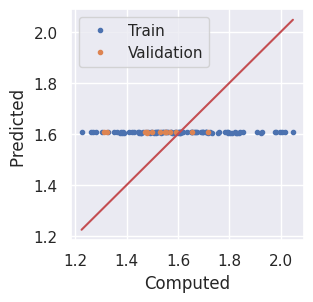

Epoch: 1, Train MAE: 0.1844, Val MAE: 0.1410
Epoch: 2, Train MAE: 0.1841, Val MAE: 0.1411
Epoch: 3, Train MAE: 0.1839, Val MAE: 0.1412
Epoch: 4, Train MAE: 0.1836, Val MAE: 0.1413
Epoch: 5, Train MAE: 0.1835, Val MAE: 0.1414
Epoch: 6, Train MAE: 0.1833, Val MAE: 0.1414
Epoch: 7, Train MAE: 0.1830, Val MAE: 0.1414
Epoch: 8, Train MAE: 0.1829, Val MAE: 0.1413
Epoch: 9, Train MAE: 0.1827, Val MAE: 0.1412
Epoch: 10, Train MAE: 0.1827, Val MAE: 0.1411


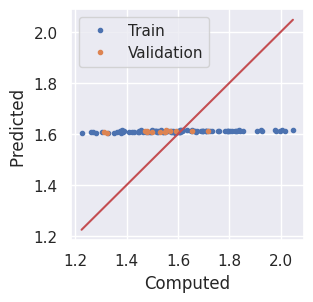

Epoch: 11, Train MAE: 0.1823, Val MAE: 0.1410
Epoch: 12, Train MAE: 0.1819, Val MAE: 0.1408
Epoch: 13, Train MAE: 0.1814, Val MAE: 0.1405
Epoch: 14, Train MAE: 0.1814, Val MAE: 0.1402
Epoch: 15, Train MAE: 0.1806, Val MAE: 0.1398
Epoch: 16, Train MAE: 0.1806, Val MAE: 0.1394
Epoch: 17, Train MAE: 0.1803, Val MAE: 0.1389
Epoch: 18, Train MAE: 0.1802, Val MAE: 0.1384
Epoch: 19, Train MAE: 0.1796, Val MAE: 0.1378
Epoch: 20, Train MAE: 0.1788, Val MAE: 0.1372


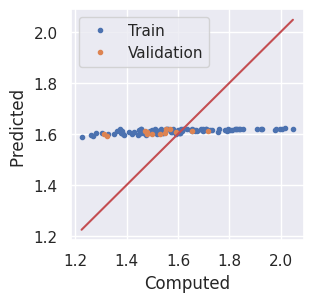

Epoch: 21, Train MAE: 0.1786, Val MAE: 0.1364
Epoch: 22, Train MAE: 0.1773, Val MAE: 0.1356
Epoch: 23, Train MAE: 0.1769, Val MAE: 0.1346
Epoch: 24, Train MAE: 0.1762, Val MAE: 0.1336
Epoch: 25, Train MAE: 0.1759, Val MAE: 0.1327
Epoch: 26, Train MAE: 0.1752, Val MAE: 0.1316
Epoch: 27, Train MAE: 0.1737, Val MAE: 0.1305
Epoch: 28, Train MAE: 0.1728, Val MAE: 0.1293
Epoch: 29, Train MAE: 0.1731, Val MAE: 0.1281
Epoch: 30, Train MAE: 0.1715, Val MAE: 0.1268


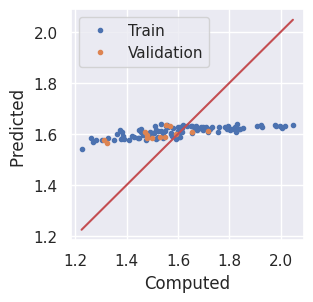

Epoch: 31, Train MAE: 0.1702, Val MAE: 0.1255
Epoch: 32, Train MAE: 0.1686, Val MAE: 0.1240
Epoch: 33, Train MAE: 0.1686, Val MAE: 0.1224
Epoch: 34, Train MAE: 0.1659, Val MAE: 0.1205
Epoch: 35, Train MAE: 0.1640, Val MAE: 0.1185
Epoch: 36, Train MAE: 0.1636, Val MAE: 0.1165
Epoch: 37, Train MAE: 0.1610, Val MAE: 0.1145
Epoch: 38, Train MAE: 0.1585, Val MAE: 0.1126
Epoch: 39, Train MAE: 0.1580, Val MAE: 0.1104
Epoch: 40, Train MAE: 0.1559, Val MAE: 0.1084


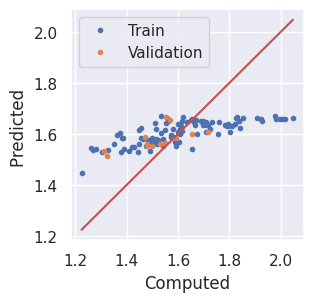

Epoch: 41, Train MAE: 0.1528, Val MAE: 0.1065
Epoch: 42, Train MAE: 0.1533, Val MAE: 0.1047
Epoch: 43, Train MAE: 0.1484, Val MAE: 0.1030
Epoch: 44, Train MAE: 0.1472, Val MAE: 0.1008
Epoch: 45, Train MAE: 0.1443, Val MAE: 0.0988
Epoch: 46, Train MAE: 0.1428, Val MAE: 0.0972
Epoch: 47, Train MAE: 0.1409, Val MAE: 0.0955
Epoch: 48, Train MAE: 0.1348, Val MAE: 0.0941
Epoch: 49, Train MAE: 0.1375, Val MAE: 0.0928
Epoch: 50, Train MAE: 0.1310, Val MAE: 0.0913


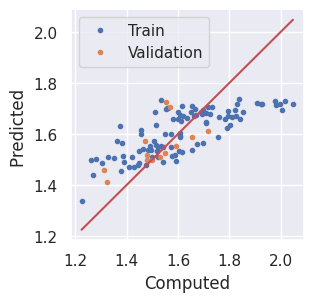

Epoch: 51, Train MAE: 0.1299, Val MAE: 0.0904
Epoch: 52, Train MAE: 0.1314, Val MAE: 0.0898
Epoch: 53, Train MAE: 0.1240, Val MAE: 0.0901
Epoch: 54, Train MAE: 0.1217, Val MAE: 0.0913
Epoch: 55, Train MAE: 0.1238, Val MAE: 0.0929
Epoch: 56, Train MAE: 0.1222, Val MAE: 0.0949
Epoch: 57, Train MAE: 0.1216, Val MAE: 0.0970
Epoch: 58, Train MAE: 0.1187, Val MAE: 0.0992
Epoch: 59, Train MAE: 0.1176, Val MAE: 0.1011
Epoch: 60, Train MAE: 0.1187, Val MAE: 0.1015


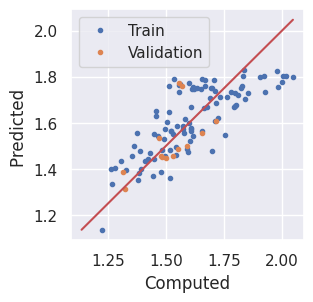

Epoch: 61, Train MAE: 0.1152, Val MAE: 0.1022
Epoch: 62, Train MAE: 0.1161, Val MAE: 0.1031
Epoch: 63, Train MAE: 0.1156, Val MAE: 0.1035
Epoch: 64, Train MAE: 0.1153, Val MAE: 0.1036
Epoch: 65, Train MAE: 0.1151, Val MAE: 0.1036
Epoch: 66, Train MAE: 0.1135, Val MAE: 0.1035
Epoch: 67, Train MAE: 0.1165, Val MAE: 0.1033
Epoch: 68, Train MAE: 0.1161, Val MAE: 0.1025
Epoch: 69, Train MAE: 0.1166, Val MAE: 0.1009
Epoch: 70, Train MAE: 0.1133, Val MAE: 0.0996


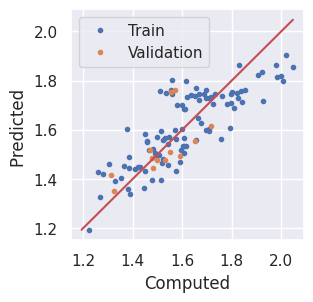

Epoch: 71, Train MAE: 0.1064, Val MAE: 0.0985
Epoch: 72, Train MAE: 0.1053, Val MAE: 0.0975
Epoch: 73, Train MAE: 0.1089, Val MAE: 0.0969
Epoch: 74, Train MAE: 0.1078, Val MAE: 0.0959
Epoch: 75, Train MAE: 0.1080, Val MAE: 0.0947
Epoch: 76, Train MAE: 0.1062, Val MAE: 0.0937
Epoch: 77, Train MAE: 0.1024, Val MAE: 0.0925
Epoch: 78, Train MAE: 0.1020, Val MAE: 0.0919
Epoch: 79, Train MAE: 0.1057, Val MAE: 0.0914
Epoch: 80, Train MAE: 0.1066, Val MAE: 0.0908


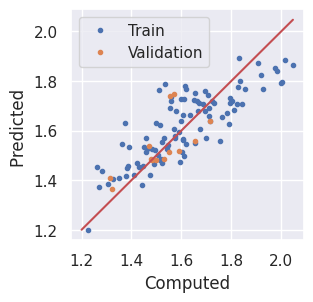

Epoch: 81, Train MAE: 0.1039, Val MAE: 0.0898
Epoch: 82, Train MAE: 0.1102, Val MAE: 0.0891
Epoch: 83, Train MAE: 0.0985, Val MAE: 0.0883
Epoch: 84, Train MAE: 0.1083, Val MAE: 0.0881
Epoch: 85, Train MAE: 0.1057, Val MAE: 0.0883
Epoch: 86, Train MAE: 0.1048, Val MAE: 0.0893
Epoch: 87, Train MAE: 0.1046, Val MAE: 0.0903
Epoch: 88, Train MAE: 0.1059, Val MAE: 0.0901
Epoch: 89, Train MAE: 0.1033, Val MAE: 0.0893
Epoch: 90, Train MAE: 0.0998, Val MAE: 0.0885


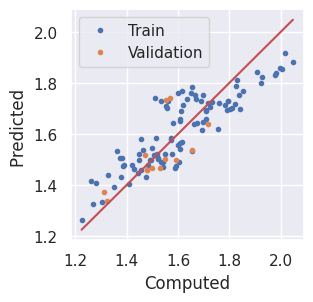

Epoch: 91, Train MAE: 0.0913, Val MAE: 0.0884
Epoch: 92, Train MAE: 0.0966, Val MAE: 0.0886
Epoch: 93, Train MAE: 0.1076, Val MAE: 0.0892
Epoch: 94, Train MAE: 0.0967, Val MAE: 0.0903
Epoch: 95, Train MAE: 0.0938, Val MAE: 0.0905
Epoch: 96, Train MAE: 0.1025, Val MAE: 0.0895
Epoch: 97, Train MAE: 0.0938, Val MAE: 0.0887
Epoch: 98, Train MAE: 0.0984, Val MAE: 0.0884
Epoch: 99, Train MAE: 0.0963, Val MAE: 0.0884
Epoch: 100, Train MAE: 0.0960, Val MAE: 0.0891


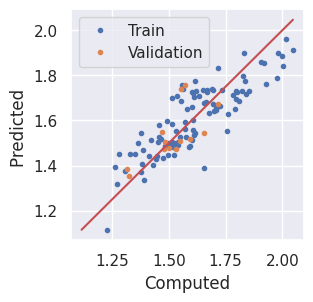

Epoch: 101, Train MAE: 0.0967, Val MAE: 0.0906
Epoch: 102, Train MAE: 0.0924, Val MAE: 0.0906
Epoch: 103, Train MAE: 0.0900, Val MAE: 0.0899
Epoch: 104, Train MAE: 0.0966, Val MAE: 0.0886
Epoch: 105, Train MAE: 0.0990, Val MAE: 0.0882
Epoch: 106, Train MAE: 0.0896, Val MAE: 0.0883
Epoch: 107, Train MAE: 0.0935, Val MAE: 0.0891
Epoch: 108, Train MAE: 0.0955, Val MAE: 0.0895
Epoch: 109, Train MAE: 0.0923, Val MAE: 0.0900
Epoch: 110, Train MAE: 0.0972, Val MAE: 0.0886


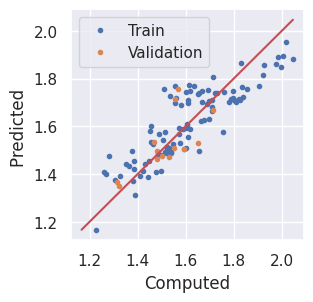

Epoch: 111, Train MAE: 0.0925, Val MAE: 0.0872
Epoch: 112, Train MAE: 0.0932, Val MAE: 0.0865
Epoch: 113, Train MAE: 0.0957, Val MAE: 0.0866
Epoch: 114, Train MAE: 0.0856, Val MAE: 0.0869
Epoch: 115, Train MAE: 0.0890, Val MAE: 0.0879
Epoch: 116, Train MAE: 0.0840, Val MAE: 0.0883
Epoch: 117, Train MAE: 0.0896, Val MAE: 0.0877
Epoch: 118, Train MAE: 0.0858, Val MAE: 0.0857
Epoch: 119, Train MAE: 0.0902, Val MAE: 0.0850
Epoch: 120, Train MAE: 0.0947, Val MAE: 0.0852


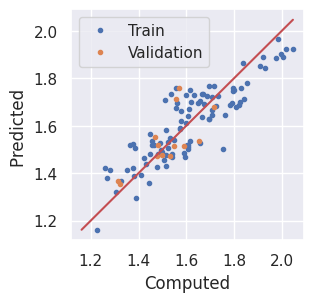

Epoch: 121, Train MAE: 0.0889, Val MAE: 0.0868
Epoch: 122, Train MAE: 0.0922, Val MAE: 0.0889
Epoch: 123, Train MAE: 0.0847, Val MAE: 0.0878
Epoch: 124, Train MAE: 0.0900, Val MAE: 0.0862
Epoch: 125, Train MAE: 0.0885, Val MAE: 0.0839
Epoch: 126, Train MAE: 0.0964, Val MAE: 0.0833
Epoch: 127, Train MAE: 0.0887, Val MAE: 0.0833
Epoch: 128, Train MAE: 0.0856, Val MAE: 0.0830
Epoch: 129, Train MAE: 0.0841, Val MAE: 0.0824
Epoch: 130, Train MAE: 0.0867, Val MAE: 0.0819


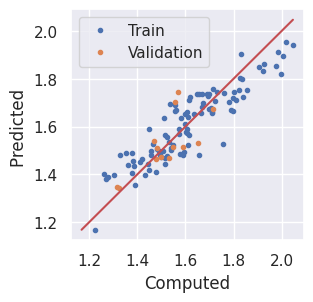

Epoch: 131, Train MAE: 0.0798, Val MAE: 0.0822
Epoch: 132, Train MAE: 0.0834, Val MAE: 0.0830
Epoch: 133, Train MAE: 0.0821, Val MAE: 0.0837
Epoch: 134, Train MAE: 0.0835, Val MAE: 0.0843
Epoch: 135, Train MAE: 0.0781, Val MAE: 0.0839
Epoch: 136, Train MAE: 0.0801, Val MAE: 0.0824
Epoch: 137, Train MAE: 0.0837, Val MAE: 0.0812
Epoch: 138, Train MAE: 0.0832, Val MAE: 0.0807
Epoch: 139, Train MAE: 0.0842, Val MAE: 0.0803
Epoch: 140, Train MAE: 0.0832, Val MAE: 0.0810


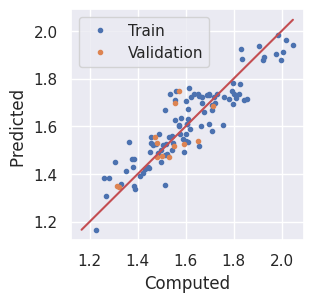

Epoch: 141, Train MAE: 0.0783, Val MAE: 0.0823
Epoch: 142, Train MAE: 0.0837, Val MAE: 0.0827
Epoch: 143, Train MAE: 0.0785, Val MAE: 0.0828
Epoch: 144, Train MAE: 0.0786, Val MAE: 0.0815
Epoch: 145, Train MAE: 0.0876, Val MAE: 0.0804
Epoch: 146, Train MAE: 0.0776, Val MAE: 0.0793
Epoch: 147, Train MAE: 0.0840, Val MAE: 0.0793
Epoch: 148, Train MAE: 0.0739, Val MAE: 0.0799
Epoch: 149, Train MAE: 0.0738, Val MAE: 0.0794
Epoch: 150, Train MAE: 0.0805, Val MAE: 0.0779


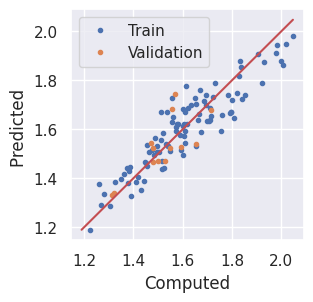

Epoch: 151, Train MAE: 0.0735, Val MAE: 0.0777
Epoch: 152, Train MAE: 0.0784, Val MAE: 0.0784
Epoch: 153, Train MAE: 0.0833, Val MAE: 0.0796
Epoch: 154, Train MAE: 0.0755, Val MAE: 0.0797
Epoch: 155, Train MAE: 0.0787, Val MAE: 0.0783
Epoch: 156, Train MAE: 0.0790, Val MAE: 0.0767
Epoch: 157, Train MAE: 0.0708, Val MAE: 0.0760
Epoch: 158, Train MAE: 0.0738, Val MAE: 0.0748
Epoch: 159, Train MAE: 0.0691, Val MAE: 0.0745
Epoch: 160, Train MAE: 0.0751, Val MAE: 0.0753


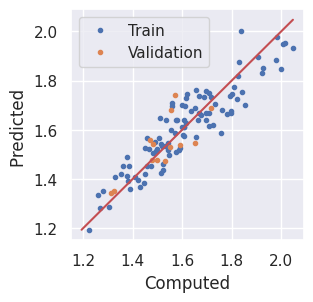

Epoch: 161, Train MAE: 0.0737, Val MAE: 0.0770
Epoch: 162, Train MAE: 0.0719, Val MAE: 0.0765
Epoch: 163, Train MAE: 0.0806, Val MAE: 0.0749
Epoch: 164, Train MAE: 0.0714, Val MAE: 0.0737
Epoch: 165, Train MAE: 0.0764, Val MAE: 0.0737
Epoch: 166, Train MAE: 0.0742, Val MAE: 0.0743
Epoch: 167, Train MAE: 0.0702, Val MAE: 0.0742
Epoch: 168, Train MAE: 0.0740, Val MAE: 0.0739
Epoch: 169, Train MAE: 0.0751, Val MAE: 0.0739
Epoch: 170, Train MAE: 0.0735, Val MAE: 0.0739


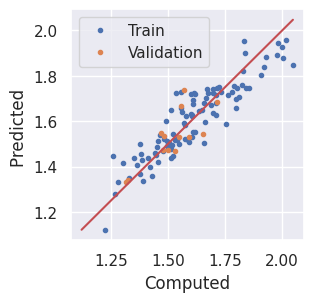

Epoch: 171, Train MAE: 0.0772, Val MAE: 0.0744
Epoch: 172, Train MAE: 0.0771, Val MAE: 0.0741
Epoch: 173, Train MAE: 0.0761, Val MAE: 0.0733
Epoch: 174, Train MAE: 0.0696, Val MAE: 0.0720
Epoch: 175, Train MAE: 0.0803, Val MAE: 0.0720
Epoch: 176, Train MAE: 0.0722, Val MAE: 0.0724
Epoch: 177, Train MAE: 0.0696, Val MAE: 0.0726
Epoch: 178, Train MAE: 0.0704, Val MAE: 0.0745
Epoch: 179, Train MAE: 0.0711, Val MAE: 0.0744
Epoch: 180, Train MAE: 0.0685, Val MAE: 0.0727


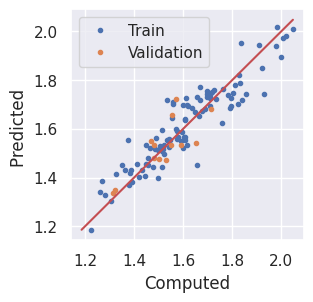

Epoch: 181, Train MAE: 0.0716, Val MAE: 0.0705
Epoch: 182, Train MAE: 0.0649, Val MAE: 0.0683
Epoch: 183, Train MAE: 0.0699, Val MAE: 0.0677
Epoch: 184, Train MAE: 0.0750, Val MAE: 0.0697
Epoch: 185, Train MAE: 0.0714, Val MAE: 0.0724
Epoch: 186, Train MAE: 0.0669, Val MAE: 0.0758
Epoch: 187, Train MAE: 0.0686, Val MAE: 0.0723
Epoch: 188, Train MAE: 0.0711, Val MAE: 0.0679
Epoch: 189, Train MAE: 0.0670, Val MAE: 0.0668
Epoch: 190, Train MAE: 0.0637, Val MAE: 0.0664


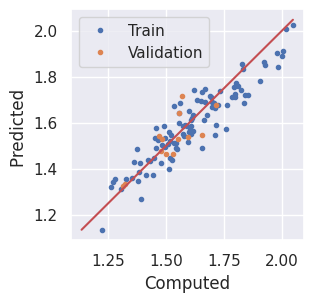

Epoch: 191, Train MAE: 0.0720, Val MAE: 0.0675
Epoch: 192, Train MAE: 0.0596, Val MAE: 0.0706
Epoch: 193, Train MAE: 0.0644, Val MAE: 0.0750
Epoch: 194, Train MAE: 0.0717, Val MAE: 0.0734
Epoch: 195, Train MAE: 0.0706, Val MAE: 0.0682
Epoch: 196, Train MAE: 0.0660, Val MAE: 0.0646
Epoch: 197, Train MAE: 0.0651, Val MAE: 0.0640
Epoch: 198, Train MAE: 0.0660, Val MAE: 0.0636
Epoch: 199, Train MAE: 0.0705, Val MAE: 0.0655
Epoch: 200, Train MAE: 0.0603, Val MAE: 0.0712


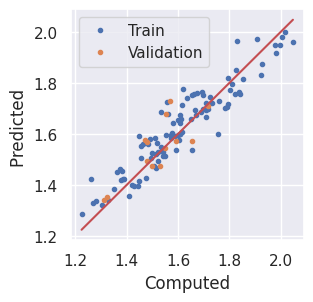

Epoch: 201, Train MAE: 0.0664, Val MAE: 0.0742
Epoch: 202, Train MAE: 0.0710, Val MAE: 0.0700
Epoch: 203, Train MAE: 0.0734, Val MAE: 0.0658
Epoch: 204, Train MAE: 0.0685, Val MAE: 0.0633
Epoch: 205, Train MAE: 0.0648, Val MAE: 0.0618
Epoch: 206, Train MAE: 0.0667, Val MAE: 0.0615
Epoch: 207, Train MAE: 0.0577, Val MAE: 0.0627
Epoch: 208, Train MAE: 0.0671, Val MAE: 0.0654
Epoch: 209, Train MAE: 0.0639, Val MAE: 0.0686
Epoch: 210, Train MAE: 0.0626, Val MAE: 0.0694


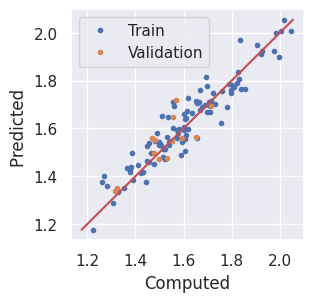

Epoch: 211, Train MAE: 0.0607, Val MAE: 0.0673
Epoch: 212, Train MAE: 0.0607, Val MAE: 0.0639
Epoch: 213, Train MAE: 0.0634, Val MAE: 0.0614
Epoch: 214, Train MAE: 0.0668, Val MAE: 0.0611
Epoch: 215, Train MAE: 0.0612, Val MAE: 0.0615
Epoch: 216, Train MAE: 0.0561, Val MAE: 0.0649
Epoch: 217, Train MAE: 0.0548, Val MAE: 0.0692
Epoch: 218, Train MAE: 0.0623, Val MAE: 0.0696
Epoch: 219, Train MAE: 0.0584, Val MAE: 0.0650
Epoch: 220, Train MAE: 0.0663, Val MAE: 0.0610


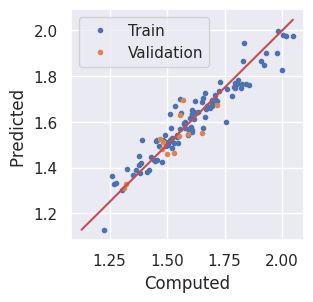

Epoch: 221, Train MAE: 0.0554, Val MAE: 0.0592
Epoch: 222, Train MAE: 0.0660, Val MAE: 0.0592
Epoch: 223, Train MAE: 0.0607, Val MAE: 0.0607
Epoch: 224, Train MAE: 0.0609, Val MAE: 0.0637
Epoch: 225, Train MAE: 0.0612, Val MAE: 0.0653
Epoch: 226, Train MAE: 0.0652, Val MAE: 0.0630
Epoch: 227, Train MAE: 0.0572, Val MAE: 0.0618
Epoch: 228, Train MAE: 0.0567, Val MAE: 0.0616
Epoch: 229, Train MAE: 0.0657, Val MAE: 0.0614
Epoch: 230, Train MAE: 0.0659, Val MAE: 0.0616


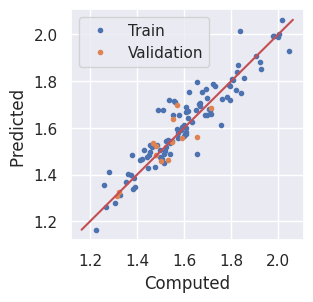

Epoch: 231, Train MAE: 0.0680, Val MAE: 0.0604
Epoch: 232, Train MAE: 0.0608, Val MAE: 0.0589
Epoch: 233, Train MAE: 0.0607, Val MAE: 0.0584
Epoch: 234, Train MAE: 0.0589, Val MAE: 0.0597
Epoch: 235, Train MAE: 0.0604, Val MAE: 0.0604
Epoch: 236, Train MAE: 0.0543, Val MAE: 0.0602
Epoch: 237, Train MAE: 0.0569, Val MAE: 0.0610
Epoch: 238, Train MAE: 0.0567, Val MAE: 0.0607
Epoch: 239, Train MAE: 0.0598, Val MAE: 0.0594
Epoch: 240, Train MAE: 0.0541, Val MAE: 0.0585


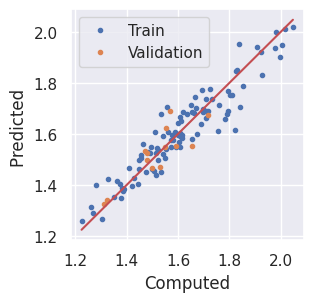

Epoch: 241, Train MAE: 0.0613, Val MAE: 0.0579
Epoch: 242, Train MAE: 0.0566, Val MAE: 0.0587
Epoch: 243, Train MAE: 0.0524, Val MAE: 0.0606
Epoch: 244, Train MAE: 0.0649, Val MAE: 0.0627
Epoch: 245, Train MAE: 0.0599, Val MAE: 0.0610
Epoch: 246, Train MAE: 0.0565, Val MAE: 0.0595
Epoch: 247, Train MAE: 0.0556, Val MAE: 0.0585
Epoch: 248, Train MAE: 0.0520, Val MAE: 0.0579
Epoch: 249, Train MAE: 0.0557, Val MAE: 0.0579
Epoch: 250, Train MAE: 0.0579, Val MAE: 0.0582


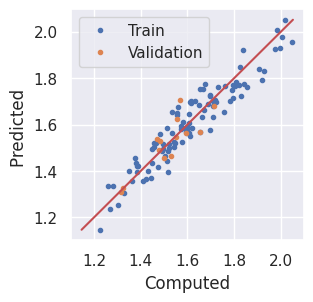

Epoch: 251, Train MAE: 0.0595, Val MAE: 0.0591
Epoch: 252, Train MAE: 0.0597, Val MAE: 0.0596
Epoch: 253, Train MAE: 0.0583, Val MAE: 0.0601
Epoch: 254, Train MAE: 0.0581, Val MAE: 0.0606
Epoch: 255, Train MAE: 0.0562, Val MAE: 0.0597
Epoch: 256, Train MAE: 0.0596, Val MAE: 0.0586
Epoch: 257, Train MAE: 0.0575, Val MAE: 0.0580
Epoch: 258, Train MAE: 0.0601, Val MAE: 0.0567
Epoch: 259, Train MAE: 0.0509, Val MAE: 0.0565
Epoch: 260, Train MAE: 0.0554, Val MAE: 0.0560


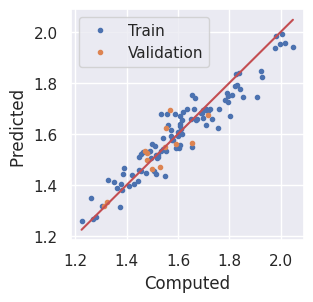

Epoch: 261, Train MAE: 0.0579, Val MAE: 0.0567
Epoch: 262, Train MAE: 0.0549, Val MAE: 0.0574
Epoch: 263, Train MAE: 0.0559, Val MAE: 0.0583
Epoch: 264, Train MAE: 0.0487, Val MAE: 0.0595
Epoch: 265, Train MAE: 0.0532, Val MAE: 0.0595
Epoch: 266, Train MAE: 0.0571, Val MAE: 0.0580
Epoch: 267, Train MAE: 0.0526, Val MAE: 0.0576
Epoch: 268, Train MAE: 0.0574, Val MAE: 0.0575
Epoch: 269, Train MAE: 0.0480, Val MAE: 0.0566
Epoch: 270, Train MAE: 0.0548, Val MAE: 0.0555


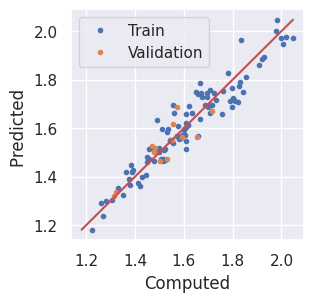

Epoch: 271, Train MAE: 0.0546, Val MAE: 0.0546
Epoch: 272, Train MAE: 0.0526, Val MAE: 0.0540
Epoch: 273, Train MAE: 0.0506, Val MAE: 0.0545
Epoch: 274, Train MAE: 0.0521, Val MAE: 0.0553
Epoch: 275, Train MAE: 0.0538, Val MAE: 0.0557
Epoch: 276, Train MAE: 0.0590, Val MAE: 0.0547
Epoch: 277, Train MAE: 0.0570, Val MAE: 0.0537
Epoch: 278, Train MAE: 0.0552, Val MAE: 0.0528
Epoch: 279, Train MAE: 0.0548, Val MAE: 0.0533
Epoch: 280, Train MAE: 0.0498, Val MAE: 0.0544


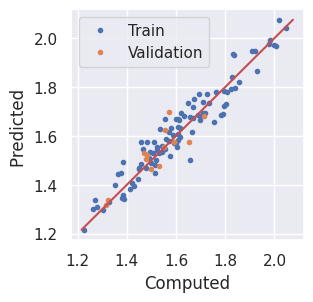

Epoch: 281, Train MAE: 0.0521, Val MAE: 0.0544
Epoch: 282, Train MAE: 0.0554, Val MAE: 0.0550
Epoch: 283, Train MAE: 0.0518, Val MAE: 0.0550
Epoch: 284, Train MAE: 0.0575, Val MAE: 0.0537
Epoch: 285, Train MAE: 0.0502, Val MAE: 0.0531
Epoch: 286, Train MAE: 0.0564, Val MAE: 0.0534
Epoch: 287, Train MAE: 0.0535, Val MAE: 0.0542
Epoch: 288, Train MAE: 0.0470, Val MAE: 0.0571
Epoch: 289, Train MAE: 0.0562, Val MAE: 0.0573
Epoch: 290, Train MAE: 0.0539, Val MAE: 0.0551


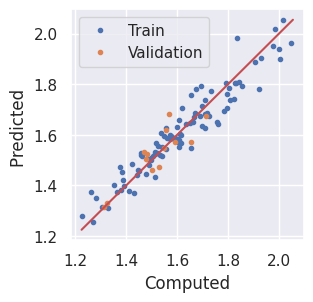

Epoch: 291, Train MAE: 0.0545, Val MAE: 0.0534
Epoch: 292, Train MAE: 0.0537, Val MAE: 0.0520
Epoch: 293, Train MAE: 0.0537, Val MAE: 0.0519
Epoch: 294, Train MAE: 0.0436, Val MAE: 0.0526
Epoch: 295, Train MAE: 0.0550, Val MAE: 0.0537
Epoch: 296, Train MAE: 0.0523, Val MAE: 0.0550
Epoch: 297, Train MAE: 0.0524, Val MAE: 0.0541
Epoch: 298, Train MAE: 0.0565, Val MAE: 0.0523
Epoch: 299, Train MAE: 0.0550, Val MAE: 0.0507
Epoch: 300, Train MAE: 0.0488, Val MAE: 0.0507


In [16]:
# Train the model
train_losses = []
val_losses   = []
for epoch in np.arange(0, n_epochs):
    train_loss, train_predictions, train_ground_truths = clm.train(model, criterion, train_loader,
                                                                   target_factor,
                                                                   standardized_parameters['target_mean'],
                                                                   optimizer)
    val_loss,   val_predictions,   val_ground_truths   =  clm.test(model, criterion, val_loader,
                                                                   target_factor,
                                                                   standardized_parameters['target_mean'])

    # Convert to original units
    train_loss = np.sum(np.sqrt(train_loss) * target_factor)
    val_loss   = np.sum(np.sqrt(val_loss)   * target_factor)

    if epoch%10 == 0:
        cld.parity_plot(train=np.array([train_ground_truths, train_predictions]),
                        validation=np.array([val_ground_truths, val_predictions]))
    
    # Append losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Check early stopping criteria
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print('Early stopping')
        break

    print(f'Epoch: {epoch+1}, Train MAE: {train_loss:.4f}, Val MAE: {val_loss:.4f}')

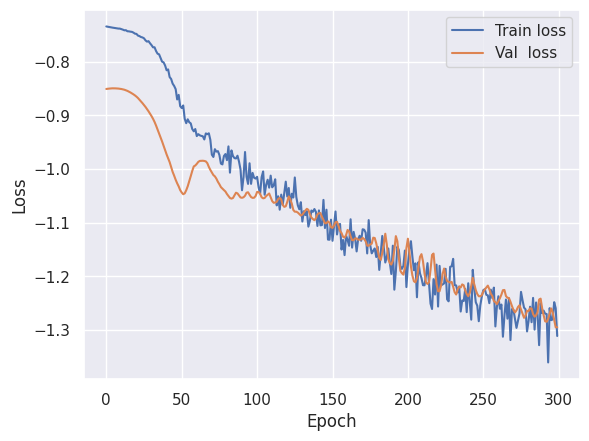

In [17]:
cld.losses_plot(train_losses=train_losses,
                val_losses=val_losses,
                to_log=True)

# Check test data

In [18]:
model = clm.load_model(n_node_features, dropout, device, model_name=files_names['model_name'], purpose='eval')
model

DataParallel(
  (module): GCNN(
    (conv1): GraphConv(4, 32)
    (conv2): GraphConv(32, 32)
    (lin1): Linear(in_features=32, out_features=32, bias=True)
    (lin2): Linear(in_features=32, out_features=16, bias=True)
    (lin): Linear(in_features=16, out_features=1, bias=True)
  )
)

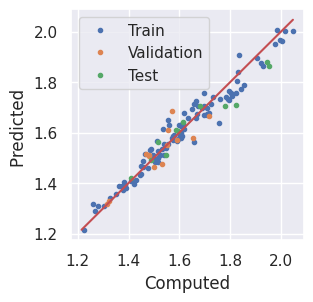

Train MAE: 0.0376, Val MAE: 0.0507, Test MAE: 0.0554


In [19]:
train_loss, train_predictions, train_ground_truths = clm.test(model, criterion, train_loader,
                                                              target_factor,
                                                              standardized_parameters['target_mean'])
val_loss,   val_predictions,   val_ground_truths   =  clm.test(model, criterion, val_loader,
                                                               target_factor,
                                                               standardized_parameters['target_mean'])
test_loss,  test_predictions,  test_ground_truths  =  clm.test(model, criterion, test_loader,
                                                               target_factor,
                                                               standardized_parameters['target_mean'])

# Pass to energy units (same as initial Fv)
train_loss = np.sum(np.sqrt(train_loss) * target_factor)
val_loss   = np.sum(np.sqrt(val_loss)   * target_factor)
test_loss  = np.sum(np.sqrt(test_loss)  * target_factor)

cld.parity_plot(train=np.array([train_ground_truths, train_predictions]),
                validation=np.array([val_ground_truths, val_predictions]),
                test=np.array([test_ground_truths, test_predictions]),
                save_to=f'{target_folder}/{target}-GCNN-training.pdf')

print(f'Train MAE: {train_loss:.4f}, Val MAE: {val_loss:.4f}, Test MAE: {test_loss:.4f}')

# Generate uncertainties and save

In [20]:
dataset = [data for dataset in [train_dataset, val_dataset] for data in dataset]

loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

loss, predictions, ground_truths = clm.test(model, criterion, loader,
                                            target_factor,
                                            standardized_parameters['target_mean'])

# label: uncertainty = ground-truth - prediction
uncertainties = ground_truths - predictions

# Generate dictionary with uncertainty data
uncertainty_data = {}
for idx in range(len(dataset)):
    uncertainty_data.update(
        {dataset[idx].label: float(uncertainties[idx])}
    )

# Dump the dictionary with numpy arrays to a JSON file
cld.save_json(uncertainty_data, files_names['uncert_data_name'])